# Loading Libraries

In [614]:
from IPython.display import Image
import pandas as pd
import numpy as np
import os
import re
import matplotlib as plt
import seaborn as sns
import random
import datetime

os.chdir('/home/code/')

# Loading Dataframe (parquet)

In [117]:
df = pd.read_parquet('customerData.parquet')
df = df.drop(columns='Unnamed: 0')

# Data Profiling Calculation
In this section some metrics are calculate from the df trying guarantee the **data quality**. We are going to calculate values like number of nulls in columns, min and max number of characters, number of unique values for each column and so on. Also, we will calculate, for variable type **date**, **id** and **email**, the number of values which doesn't match on a given **pattern** that determines the **correct format** of the variable. We're going to start with that measure. 


First, lets take a look over the dataframe in order to know what we understand by **correct format** of each variable. A random sample of 10 registers will be useful for that. 

In [76]:
df.sample(10)

,customerID,date,paymentMethod,ticketNumber,ticketNumberDetail,value,discount,createdBy,custCreationDate,idType,...,itemLine,itemSubline,itemRegulated,itemApplications,itemLevel,storeID,dayOfYear,dayOfWeek,yearMonth,dayName
254643,PDV,2021-07-09,CON,96D2FAFB-F0E0-EB11-963E-8DF9F20FE42C,97D2FAFB-F0E0-EB11-963E-8DF9F20FE42C,107100.0,0.0,wrocha,2013-01-02 00:00:00.000,C,...,PLAGUICIDAS,INSECTICIDAS,NO,AGRICULTURA,GAMA MEDIA,16,190,6,2021-07,Friday
29791,PDV,2020-09-17,CON,9F6FCDA7-EBF8-EA11-9EBE-448A5B481A00,A06FCDA7-EBF8-EA11-9EBE-448A5B481A00,11200.0,0.0,ericda,2013-01-02 00:00:00.000,C,...,PLAGUICIDAS,INSECTICIDAS,NO,AGRICULTURA,GAMA MEDIA,16,261,5,2020-09,Thursday
418753,PDV,2020-10-16,CON,746796F7-FB0F-EB11-BD56-B1B042CE9355,756796F7-FB0F-EB11-BD56-B1B042CE9355,12667.0,0.0,amin,2013-01-02 00:00:00.000,C,...,ALIMENTO PARA PERROS,SEGMENTO PREMIUM,NO,MASCOTAS,GAMA MEDIA,17,290,6,2020-10,Friday
3515,35112329,2021-06-10,CON,9A4EE56C-F7C9-EB11-BD67-BECB738B5CB3,9C4EE56C-F7C9-EB11-BD67-BECB738B5CB3,43600.0,0.0,luisfg,2014-08-19 00:00:00.000,C,...,ANTIPARASITARIOS,ECTOPARASITICIDAS PEQUE¥OS ANIMALES,NO,MASCOTAS,GAMA ALTA,17,161,5,2021-06,Thursday
180100,PDV,2020-11-20,CON,5E9E50B7-642B-EB11-A43E-A4BB6DA98B46,609E50B7-642B-EB11-A43E-A4BB6DA98B46,1.0,0.0,amin,2013-01-02 00:00:00.000,C,...,IMPLEMENTOS VARIOS,None,NO,CONSUMO,GAMA BAJA,17,325,6,2020-11,Friday
150362,PDV,2020-05-08,CON,76560E66-4191-EA11-8115-848F69F92110,77560E66-4191-EA11-8115-848F69F92110,4900.0,0.0,luisfg,2013-01-02 00:00:00.000,C,...,ANTIPARASITARIOS,ANTIHELMINTICOS,NO,MASCOTAS,GAMA MEDIA,17,129,6,2020-05,Friday
483969,40467897,2020-06-25,CON,94C82DFA-2DB7-EA11-B9B5-842B2BAAF117,95C82DFA-2DB7-EA11-B9B5-842B2BAAF117,292800.0,0.0,greisyb,2014-06-14 00:00:00.000,C,...,SOLUCIONES HIDRATANTES,INYECTABLES,NO,GANADERÍA BOVINA,GAMA ALTA,10,177,5,2020-06,Thursday
331165,PDV,2020-12-15,CON,AD39FE34-0E3F-EB11-A445-A4BB6DA98B46,E812CB63-0E3F-EB11-A445-A4BB6DA98B46,14.0,0.0,amin,2013-01-02 00:00:00.000,C,...,IMPLEMENTOS VARIOS,None,NO,CONSUMO,GAMA BAJA,17,350,3,2020-12,Tuesday
220640,PDV,2020-08-05,CON,E8DA83F3-44D7-EA11-962E-D8CB8A448819,E9DA83F3-44D7-EA11-962E-D8CB8A448819,1429.0,0.0,jmenco,2013-01-02 00:00:00.000,C,...,ALIMENTO PARA AVES,None,NO,AVICULTURA,GAMA MEDIA,16,218,4,2020-08,Wednesday
439639,PDV,2021-08-10,CON,5E168C14-F5F9-EB11-9EDD-448A5B481A00,6A6F2247-F5F9-EB11-9EDD-448A5B481A00,34700.0,0.0,ericda,2013-01-02 00:00:00.000,C,...,OTROS FARMACEUTICOS,None,NO,MASCOTAS,GAMA MEDIA,16,222,3,2021-08,Tuesday


In the last sample we can see things like: ```date``` comes in date format, but other time variables comes in datetime. There are a very clear rule for identify the ticket number, some ids are ints or floats (which can suggest the presence of null values) and so on. We will be using **regex** to create patterns that express those rules and filter the data looking for wrong entrances. 

The three next functions process the df, select the columns with wrong entrances and return the number of wrong entrances per column and the wrong values with its **frequency**.

In [216]:
def pattern_match(value, pattern):
    value = str(value)
    if re.fullmatch(pattern, value) == None:
        return False
    else:
        return True

In [356]:
def filter_matches(data_f, col_name, pattern):
    base_series = data_f[col_name].dropna()
    bool_column = base_series.apply(pattern_match, args=(pattern))
    result = base_series[~(bool_column)] 
    num_not_match = bool_column.count() - bool_column.sum()
    errors = result.value_counts().reset_index()

    return num_not_match, errors
    
    

In [357]:
def patternizer(df):
    
    dict_of_re_patterns = {'date': ['\d{4,4}-\d{2,2}-\d{2,2}'],
                       'customerID':['\d*'],
                      'ticketNumber':['[\dA-Z]{8,8}-[\dA-Z]{4,4}-[\dA-Z]{4,4}-[\dA-Z]{4,4}-[\dA-Z]{12,12}'],
                      'ticketNumberDetail':['[\dA-Z]{8,8}-[\dA-Z]{4,4}-[\dA-Z]{4,4}-[\dA-Z]{4,4}-[\dA-Z]{12,12}'],
                      'custCreationDate':['\d{4,4}-\d{2,2}-\d{2,2} \d{2,2}:\d{2,2}:\d{2,2}\.\d{3,3}'],
                      'birthDate':['\d{4,4}-\d{2,2}-\d{2,2} \d{2,2}:\d{2,2}:\d{2,2}\.\d{3,3}'],
                      'custCity':['\d+.?\d*'],
                      'custEmail':['[-\.\w]+@[\w]+\.[\w]+\.?[\w]*.?[\w]* *'],
                      'itemID':['\d+.?\d*'],
                      'itemCreationDate':['\d{4,4}-\d{2,2}-\d{2,2} \d{2,2}:\d{2,2}:\d{2,2}\.\d{3,3}'],
                      'storeID':['\d+.?\d*']}
    
    not_match_values = {}
    errors_dict = {}
    for index,value in dict_of_re_patterns.items():
        num, error = filter_matches(df, index,value)
        not_match_values[index]= num
        if error.shape[0]==0:
            continue
        else:
            errors_dict[index]=error
            
    return not_match_values, errors_dict
    

We can now calculate the wrong entrances but also the other measures that will be into the data profiling process

In [358]:
not_match_values, errors_dict = patternizer(df)

In [359]:
count_dict = {x: df.shape[0] for x in df.columns.tolist()}
not_null = df.notna().sum()
null_dict_total = df.isna().sum()
null_dict_perc=(null_dict_total/df.shape[0]).to_dict()

In [360]:
def count_characters(value):
    return len(value)

In [361]:
characters = df.astype(str).applymap(count_characters)
characters_max = characters.max()
characters_min = characters.min()
del characters

In [362]:
def unique_values(df):
    unique = {}
    
    for column in df.columns.tolist():
        unique[column] = len(df[column].unique().tolist())
    return unique

In [363]:
unique_values_dict = unique_values(df)

# Data Profiling Results
Once we have our metrics is time to display them in order to understand the data more deeply. 


In [366]:
cols_names = ['not_match_regex','count', 'not_null_total', 'null_total', 'null_percentaje', 'max_characters',
             'min_characters', 'unique_values']

In [372]:
pd.DataFrame([not_match_values,count_dict, not_null, null_dict_total, null_dict_perc, 
             characters_max, characters_min, unique_values_dict], index=cols_names).transpose(
        ).sort_values(by='unique_values')

,not_match_regex,count,not_null_total,null_total,null_percentaje,max_characters,min_characters,unique_values
storeID,0.0,538421.0,538421.0,0.0,0.000000,2.0,2.0,3.0
itemRegulated,NaN,538421.0,534977.0,3444.0,0.006396,4.0,2.0,3.0
businessUnit,NaN,538421.0,535028.0,3393.0,0.006302,12.0,4.0,4.0
category,NaN,538421.0,217763.0,320658.0,0.595553,6.0,4.0,4.0
gender,NaN,538421.0,534112.0,4309.0,0.008003,3.0,3.0,4.0
itemLevel,NaN,538421.0,534982.0,3439.0,0.006387,10.0,4.0,4.0
paymentMethod,NaN,538421.0,535527.0,2894.0,0.005375,4.0,3.0,6.0
dayOfWeek,NaN,538421.0,538421.0,0.0,0.000000,1.0,1.0,7.0
idType,NaN,538421.0,534112.0,4309.0,0.008003,4.0,1.0,7.0
dayName,NaN,538421.0,538421.0,0.0,0.000000,9.0,6.0,7.0


In [371]:
df.describe()[['value','discount']].round(1)

,value,discount
count,535525.0,538421.0
mean,21045.6,57.5
std,49597.4,1392.3
min,0.0,0.0
25%,4000.0,0.0
50%,10000.0,0.0
75%,22800.0,0.0
max,7600000.0,378000.0


We can also view the wrong data filter above and the unique values of some variables like, for example ```storeID```, ```category``` and ```itemGroup```

# Unique values

In [400]:
df.storeID.value_counts().reset_index().rename(columns={'index':'storeID', 'storeID':'frequency'})

,storeID,frequency
0,16,284616
1,17,175287
2,10,78518


In [384]:
df.category.value_counts().reset_index().rename(columns={'index':'category', 'category':'frequency'})

,category,frequency
0,PERROS,191601
1,GATOS,25143
2,AVES,1019


In [385]:
df.itemGroup.value_counts().reset_index().rename(columns={'index':'itemGroup', 'itemGroup':'frequency'})

,itemGroup,frequency
0,FARMACEUTICOS,195017
1,ALIMENTOS CONCENTRADOS,124521
2,LINEA VARIOS,93775
3,AGROQUIMICOS,46732
4,DOMESTICO,22630
5,ACCESORIOS,19946
6,FERRETERIA,10166
7,INSTRUMENTAL,6659
8,SALES Y SUPLEMENTOS,4821
9,SEMILLAS,4668


# Wrong values


In [392]:
errors_dict['customerID'].rename(columns={'index':'customerID', 'customerID':'frequency'})

,customerID,frequency
0,PDV,396849
1,64617-248,33
2,OOACRGS,31
3,p,7
4,86301.070,5
5,16VD,3
6,58-02368510,3
7,A COOEOGAIEMS GTILNC,2
8,.11731193,2
9,ldnoznagrn ehaeezls,1


* What's PDV and why is the most common value of this column?

In [393]:
errors_dict['birthDate'].rename(columns={'index':'birthDate', 'birthDate':'frequency'})

,birthDate,frequency
0,NaT,463132


* In the errors of ```birthDate``` is obviously that the error is actually a null value that wasn't catched by the program

In [394]:
errors_dict['custEmail'].rename(columns={'index':'custEmail', 'custEmail':'frequency'})

,custEmail,frequency
0,1,89
1,sarmientoney@gmail.com ledarouse@hotmail.com,33
2,S,18
3,COO@MII,7
4,M,4
5,www,2
6,LEIDISL@HOTMAIL,2


* Some emails wasn't input in a correct format, we should check closely over the design of our applications to solve this problem

Now that we know how much unique values are inside the columns, we can notice that some variables has a few number of them. A good threshold for capture them could be ```unique_values > 150```. Those variables are useful grouping the dataframe in the BI process and are also good candidates for cluster the df, we could use them later. 

After that, there are four variables which don't increase our information but make the dataframe bigger in memory. Those are  ```'dayOfYear'```, ```'dayOfWeek'```, ```'yearMonth'```and```'dayName'```. Since we have ```date``` in our dataset and that variable is the base granular data of the mentioned variables, those ones are irrelevants at least in this part of the process. We can calculate them if is necessary after process the data, in the BI stage.



In [377]:
df = df.drop(columns=['dayOfYear','dayOfWeek', 'yearMonth', 'dayName'])

### CLEANING WRONG VALUES

The wrong data must be cleaned in order to keep de quality of data. How are we going to do that? The wrong values in birthDate are, as we know, null values which are not consider like that by the program, lets check if there are more null values in that column that are not ```NaT```

**Cleaning ```birthDate```**

In [536]:
df.birthDate.isna().sum()

4309

There are 4309 null values that are not ```Nat```, how they look like?

In [538]:
df.birthDate[df.birthDate.isna()]

0         None
1         None
218       None
219       None
220       None
          ... 
537408    None
537409    None
537484    None
537485    None
537522    None
Name: birthDate, Length: 4309, dtype: object

Those nulls are python builtin null values. We want to homogenenize the null values in that column, then we will replace ```NaT``` with ```None```

In [541]:
df.birthDate = df.birthDate.replace('NaT', None)

**Cleaning ```custEmail```**

In [544]:
df.custEmail.isna().sum()

498051

What about ```custEmail```. We found seven wrong emails in that column, how can we clean them? For the business is not useful to have those wrong emails in there because could create errors in email ads campaigns or related problems. Also, are not useful at all because we can't contact any client with that information. Finally, as we can see in the last cell, there are few customers whom provides an email direction. Considering that, the best option is to delete those wrong values.

In [545]:
# Saving the wrong values table into a variable
custEmailWrong = errors_dict['custEmail'].rename(columns={'index':'custEmail', 'custEmail':'frequency'})

In [552]:
df.custEmail = df.custEmail.replace({x:None for x in custEmailWrong.custEmail.tolist()})

**Cleaning ```customerID```**

The last variable we're going to clean is ```customerID```. This variable wrong values are so particular, first we have the value ```PDV``` which is actually the most common in the column, and the other wrong values can not be deleted just like that because, what if those are unique customers ids that, even if doesn't match with the pattern, work just like any other customer id? In order to solve this problem lets set a hypothesis:

* ```PDV``` is a value that represent the null value in customerID column.

How can we check that? Lets filter our dataframe for watch only the rows with ```customerID``` equals ```PDV``` and then we will check the content of the customer related columns ```customerID```, ```custCity```, ```custCreationDate```, ```custEmail```, ```custHood```, ```birthDate``` and ```gender```

In [592]:
df[df.customerID == 'PDV'][['customerID', 
                            'custCity', 'custCreationDate', 
                            'custEmail', 'custHood', 'birthDate', 'gender']].drop_duplicates()

,customerID,custCity,custCreationDate,custEmail,custHood,birthDate,gender
22,PDV,1.0,2013-01-02 00:00:00.000,None,None,None,NaN


In [568]:
df[(df.customerID == 'PDV')].gender.value_counts()

2.0    396849
Name: gender, dtype: int64

There are two things that call my attention in here. First, ```PDV``` is a created client which has a city, maybe is a special client which is also the best customer of the enterprise, maybe our business is mainly a provider of another business and the final customer (normal people) is not our main market. Our hypotesis is false. Second, ```PDV``` has a gender. As we saw in the profiler, gender has three unique values which are 0, 1, 2 and a four value which is `nan`. Then the question is, those values are male, female and _enterprise_ or there is a mistake in here? Lets check the gender unique values without consider ```PDV```.

**Note:** Save a customer id as `PDV` is a bad practice!

In [566]:
df[~(df.customerID == 'PDV')].gender.value_counts()

0.0    73237
2.0    40181
1.0    23845
Name: gender, dtype: int64

There are an important number of `2` gender values, so we can not say that there are two gender values, actually there could be an `others` or `prefer dont say` value inside of them. Then we are going to make an assumption: ```PDV``` is an enterprise customer, so has no gender. That means that the ```PDV``` gender can be deleted. But what happen if our assumption is false? Ok, in that case we can add the value 2 to the gender column for `PDV` and there is no lost of information.

In [573]:
def pdv_gender(value):
    #This function creates a column of kind of bool values which later
    #multiplies the original gender column in order to replace with nan the
    #gender of PDV
    if value == 'PDV':
        return np.nan
    else:
        return 1

In [574]:
df['gender_bool_multiplier'] = df.customerID.apply(pdv_gender)

In [575]:
df['gender_test'] = df.gender_bool_multiplier * df.gender

In [576]:
## Checking if gender_test matches with our expectations
df[(df.customerID == 'PDV')].gender_test.value_counts()

Series([], Name: gender_test, dtype: int64)

In [577]:
df[~(df.customerID == 'PDV')].gender_test.value_counts()

0.0    73237
2.0    40181
1.0    23845
Name: gender_test, dtype: int64

In [578]:
# Replacing gender with gender_test but keeping the previous column name
df = df.drop(columns='gender').rename(columns={'gender_test':'gender'})

In [582]:
# last check
df[(df.customerID == 'PDV')].gender.value_counts()

Series([], Name: gender, dtype: int64)

In [583]:
df[~(df.customerID == 'PDV')].gender.value_counts()

0.0    73237
2.0    40181
1.0    23845
Name: gender, dtype: int64

Now that we know that `PDV` is actually a client, what happens with the other wrong ids? Lets check them using a drop_duplicates over all the customer related variables but considering only those wrongs ids.

In [589]:
# Saving errors df of customerID
errors_cust_id = errors_dict['customerID'].rename(columns={'index':'customerID', 'customerID':'frequency'})
errors_cust_id_clean = errors_cust_id.customerID.tolist()
errors_cust_id_clean.remove('PDV')

In [591]:
df[df.customerID.isin(errors_cust_id_clean)][['customerID', 
                            'custCity', 'custCreationDate', 
                            'custEmail', 'custHood', 'birthDate', 'gender']].drop_duplicates()

,customerID,custCity,custCreationDate,custEmail,custHood,birthDate,gender
9773,ldnoznagrn ehaeezls,836.0,2020-04-17 00:00:00.000,None,None,None,0.0
15323,64617-248,1.0,2018-08-21 00:00:00.000,JULIANTAYRONA1@GMAIL.COM,None,1984-06-08 00:00:00.000,0.0
24889,A COOEOGAIEMS GTILNC,1.0,2013-03-06 00:00:00.000,None,CENTRO,None,0.0
28117,OOACRGS,1.0,2013-07-31 00:00:00.000,None,None,None,0.0
33599,p,1.0,2018-10-03 00:00:00.000,None,None,None,0.0
40379,91555800 86,1.0,2015-10-22 00:00:00.000,None,None,None,0.0
47875,16VD,421.0,2013-02-02 00:00:00.000,None,None,2013-02-02 00:00:00.000,0.0
82256,.11731193,1.0,2021-01-27 00:00:00.000,None,None,None,0.0
82345,8850990-282,836.0,2021-01-27 00:00:00.000,None,None,None,0.0
121267,-0856360641,1.0,2015-01-27 00:00:00.000,None,None,None,0.0


As we can see, those wrong values are customers which have even email, hood, city, and birthdate as any other client. We saw above that `customerID` has not null values, then we can assume that this value can't be empty in the sale entrance. The best option we can take here is let the wrong values as them are and wait for more info after take a different decission. We should also review the algorithm that creates the ids in order to avoid more of this wrong values in the future

# Solving Redundancy
As we can see, our data creates a record for each sale done in the store. We have the ```paymentMethod```, the ```value``` of the transaction but also we have values like the ```birthDate``` of the customer which, even if can gave us an important info about our clients, we don't need to repeat them for each buy done by an specific client. That increases the size of our data unnecessarily, so we will create a relational model over the data to solve that problem.

The excecise requires additional info about customer city from [here](https://www.datos.gov.co/Mapas-Nacionales/Departamentos-y-municipios-de-Colombia/xdk5-pm3f) but there is not a clear rule to match custCity with that information. Lets take a look over the data.

In [596]:
dptos = pd.read_parquet('cityCol.parquet')

In [597]:
dptos.head(5)

,region,dane_dpto,dpto,dane_munipo,munipo
0,Región Eje Cafetero - Antioquia,5,Antioquia,5.001,Medellín
1,Región Eje Cafetero - Antioquia,5,Antioquia,5.002,Abejorral
2,Región Eje Cafetero - Antioquia,5,Antioquia,5.004,Abriaquí
3,Región Eje Cafetero - Antioquia,5,Antioquia,5.021,Alejandría
4,Región Eje Cafetero - Antioquia,5,Antioquia,5.030,Amagá


In [603]:
print('in dane_munipo.', ' max:', dptos.dane_munipo.max(), ',', ' min:', dptos.dane_munipo.min())

in dane_munipo.  max: 99.773 ,  min: 5.001


In [605]:
df.custCity.unique()

array([ nan,   1., 770., 372., 836., 101., 205., 520., 442., 758.,   2.,
       634., 433., 551., 675., 558., 541., 573.,  52., 638., 161., 104.,
       685., 560.,  78., 642., 421., 745., 137., 555., 683., 296., 248.,
       140., 436., 654., 838., 606.,   5., 430., 873., 832.,  99., 647.,
       849., 605.,   6., 141., 628., 897., 549., 713.])

We have here a code with four to five characters and in our data frame `custCity` has one to three. We also notice that the first part of `dane_munipo` code is the same that `dane_dpto`, that may give us a clue: if we drop the dpto code inside the munipo code we can have our desired data. Lets do that

In [606]:
dptos['munip_tres'] = (dptos.dane_munipo)-(dptos.dane_munipo).astype(int)

In [609]:
dptos.sort_values(by='munip_tres').head(50).reset_index()

,index,region,dane_dpto,dpto,dane_munipo,munipo,munip_tres
0,555,Región Caribe,44,La Guajira,44.001,Riohacha,0.001
1,1085,Región Centro Oriente,54,Norte de Santander,54.001,Cúcuta,0.001
2,519,Región Centro Sur,41,Huila,41.001,Neiva,0.001
3,671,Región Eje Cafetero - Antioquia,63,Quindío,63.001,Armenia,0.001
4,615,Región Pacífico,52,Nariño,52.001,Pasto,0.001
5,592,Región Llano,50,Meta,50.001,Villavicencio,0.001
6,568,Región Caribe,47,Magdalena,47.001,Santa Marta,0.001
7,953,Región Centro Oriente,11,Bogotá D.C.,11.001,Bogotá D.C.,0.001
8,170,Región Centro Oriente,15,Boyacá,15.001,Tunja,0.001
9,121,Región Caribe,8,Atlántico,8.001,Barranquilla,0.001


What a big deal we have encounter here! The code `001` es repeated 33 time! Those values seems to be de Departament capitals except for Agua de Dios, Cundinamarca. Maybe that value has te code `001` because of its place in the list of Cundinamarca's municipes alphabeticaly. Lets check

In [610]:
dptos[dptos.dpto=='Cundinamarca'].sort_values(by='munipo').head(5)

,region,dane_dpto,dpto,dane_munipo,munipo,munip_tres
944,Región Centro Oriente,25,Cundinamarca,25.001,Agua de Dios,0.001
1053,Región Centro Oriente,25,Cundinamarca,25.019,Albán,0.019
399,Región Centro Oriente,25,Cundinamarca,25.035,Anapoima,0.035
1062,Región Centro Oriente,25,Cundinamarca,25.040,Anolaima,0.040
463,Región Centro Oriente,25,Cundinamarca,25.599,Apulo,0.599


That's exactly the reason. 

How we are facing a problem, our `custCity` variable has not enought information to make a perfect match with the city code table. The values different to `001` have not a clear pattern which specifies why a code is assigned to a city, then we basically have two big groups not perfectly divided: **Capital** and **Non capital** cities. Is not a perfect division because Agua de Dios is not capital from Cundinamarca, but we can't filter our `df` to select Agua de Dios. Then, lets make the next assumption: Agua de Dios is a very small town in comparison with the whole departament capitals together, so we can say that the code `1` in `custCity` goes for Capital cities and the error margin will be almost irrelevant. We can be wrong if the main city of our business is Agua de Dios, but even in that case, the number of registers for `1` is around 48 bigger than the whole population in Agua de Dios! Our assumtion seems very secure.

Our relational model will be something like this:

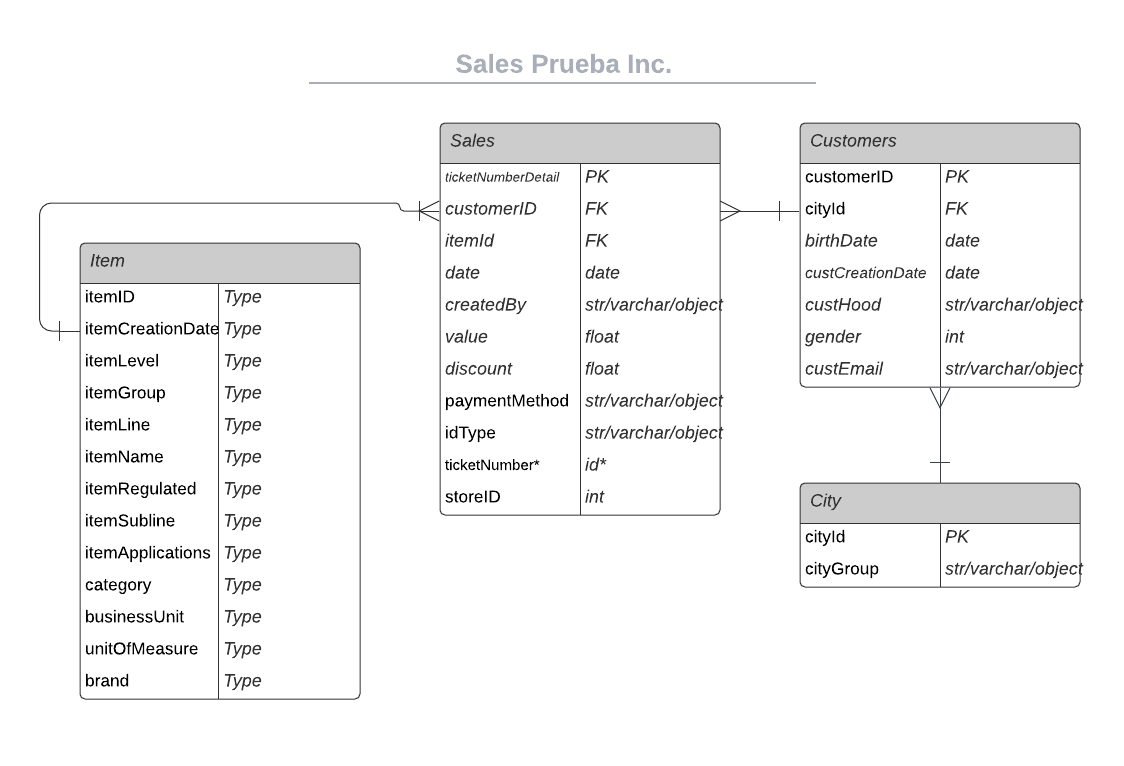

In [615]:
Image('pruebainc.png')

In [611]:
df.custCity.value_counts()

1.0      481360
836.0     49480
758.0       584
573.0       502
101.0       399
433.0       290
685.0       273
520.0       246
560.0       134
675.0        83
551.0        78
638.0        74
634.0        49
78.0         49
52.0         48
745.0        44
606.0        38
541.0        36
137.0        33
770.0        31
372.0        28
873.0        27
430.0        22
642.0        20
838.0        16
2.0          15
104.0        15
161.0        13
442.0        11
558.0        11
205.0        10
296.0        10
6.0           8
683.0         7
99.0          5
897.0         5
849.0         5
654.0         5
140.0         5
555.0         5
436.0         4
605.0         4
628.0         3
549.0         3
421.0         3
713.0         3
141.0         2
5.0           2
248.0         2
647.0         1
832.0         1
Name: custCity, dtype: int64

In [433]:
total_columns = set(df.columns.tolist())
total_columns

{'birthDate',
 'brand',
 'businessUnit',
 'category',
 'createdBy',
 'custCity',
 'custCreationDate',
 'custEmail',
 'custHood',
 'customerID',
 'date',
 'discount',
 'gender',
 'idType',
 'itemApplications',
 'itemCreationDate',
 'itemGroup',
 'itemID',
 'itemLevel',
 'itemLine',
 'itemName',
 'itemRegulated',
 'itemSubline',
 'paymentMethod',
 'storeID',
 'ticketNumber',
 'ticketNumberDetail',
 'unitOfMeasure',
 'value'}

In [434]:
customers = set(('customerID', 'custCity', 'custCreationDate', 'custEmail', 'custHood', 'birthDate', 'gender'))

In [435]:
col_nocost = total_columns - customers
col_nocost

{'brand',
 'businessUnit',
 'category',
 'createdBy',
 'date',
 'discount',
 'idType',
 'itemApplications',
 'itemCreationDate',
 'itemGroup',
 'itemID',
 'itemLevel',
 'itemLine',
 'itemName',
 'itemRegulated',
 'itemSubline',
 'paymentMethod',
 'storeID',
 'ticketNumber',
 'ticketNumberDetail',
 'unitOfMeasure',
 'value'}

In [440]:
items = set(('itemApplications', 'itemCreationDate', 'itemGroup', 'itemID', 'itemLevel', 'itemLine', 
             'itemName', 'itemRegulated', 'itemSubline', 'brand', 'businessUnit', 'category', 'unitOfMeasure'))

In [441]:
col_nocost_noitem = col_nocost - items
col_nocost_noitem

{'createdBy',
 'date',
 'discount',
 'idType',
 'paymentMethod',
 'storeID',
 'ticketNumber',
 'ticketNumberDetail',
 'value'}

In [ ]:
# sales, customers, items, city, dpto

In [ ]:
# sales, PK = ticketNumberDetail, FK = 'custId', FK = 'itemId'

In [ ]:
# customers, PK = custId, FK = cityId

In [447]:
customers

{'birthDate',
 'custCity',
 'custCreationDate',
 'custEmail',
 'custHood',
 'customerID',
 'gender'}

In [ ]:
# item, PK = itemId

In [450]:
items

{'brand',
 'businessUnit',
 'category',
 'itemApplications',
 'itemCreationDate',
 'itemGroup',
 'itemID',
 'itemLevel',
 'itemLine',
 'itemName',
 'itemRegulated',
 'itemSubline',
 'unitOfMeasure'}

In [ ]:
# City, PK = CityId, FK = DptoId

In [ ]:
# Dpto, PK = dptoId

In [516]:
dptos.sort_values('munipo_tresdigits').head(60)

,region,dane_dpto,dpto,dane_munipo,munipo,munipo_tresdigits
121,Región Caribe,8,Atlántico,8000,Barranquilla,000
0,Región Eje Cafetero - Antioquia,5,Antioquia,5001,Medellín,001
830,Región Llano,81,Arauca,81001,Arauca,001
693,Región Centro Oriente,68,Santander,68001,Bucaramanga,001
592,Región Llano,50,Meta,50001,Villavicencio,001
681,Región Eje Cafetero - Antioquia,66,Risaralda,66001,Pereira,001
671,Región Eje Cafetero - Antioquia,63,Quindío,63001,Armenia,001
170,Región Centro Oriente,15,Boyacá,15001,Tunja,001
903,Región Llano,95,Guaviare,95001,San José del Guaviare,001
376,Región Caribe,23,Córdoba,23001,Montería,001


In [446]:
df.storeID

0         10
1         10
2         10
3         10
4         10
          ..
538416    16
538417    16
538418    16
538419    16
538420    16
Name: storeID, Length: 538421, dtype: int64

In [525]:
df.drop(columns = 'munip_tres')

,customerID,date,paymentMethod,ticketNumber,ticketNumberDetail,value,discount,createdBy,custCreationDate,idType,...,brand,itemGroup,category,businessUnit,itemLine,itemSubline,itemRegulated,itemApplications,itemLevel,storeID
0,None,2021-06-11,None,183C93C6-08CB-EB11-B636-AC82478FB6A9,None,NaN,0.0,None,2000-01-01 00:00:00.000,None,...,None,None,None,None,None,None,None,None,None,10
1,None,2021-06-11,None,A938A208-09CB-EB11-B638-AC82478FA8AD,None,NaN,0.0,None,2000-01-01 00:00:00.000,None,...,None,None,None,None,None,None,None,None,None,10
2,26557317,2021-06-11,CON,916A5D76-B4CA-EB11-B636-AC82478FB6A9,7AC93ADA-B4CA-EB11-B636-AC82478FB6A9,51100.0,0.0,victor,2013-01-26 00:00:00.000,C,...,KYROVET,FARMACEUTICOS,None,AGROPECUARIO,VITAMINAS Y MINERALES,FOSFORO PREPARACIONES,NO,GANADERÍA BOVINA,GAMA BAJA,10
3,26557317,2021-06-11,CON,916A5D76-B4CA-EB11-B636-AC82478FB6A9,D44DFE12-B5CA-EB11-B636-AC82478FB6A9,1.0,0.0,victor,2013-01-26 00:00:00.000,C,...,VARIOS,LINEA VARIOS,None,CONSUMO,IMPLEMENTOS VARIOS,None,NO,CONSUMO,GAMA BAJA,10
4,2041175771,2021-06-11,CON,B3267A6E-B8CA-EB11-B636-AC82478FB6A9,B4267A6E-B8CA-EB11-B636-AC82478FB6A9,4000.0,0.0,victor,2021-03-18 00:00:00.000,C,...,PEDIGREE,ALIMENTOS CONCENTRADOS,None,MASCOTAS,ALIMENTO PARA PERROS,SNACKS,NO,MASCOTAS,GAMA MEDIA,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
538416,97037570,2020-05-29,CON,C5E61F8C-E6A1-EA11-9EB5-4437E6EC175B,A5F56192-E6A1-EA11-9EB5-4437E6EC175B,31200.0,0.0,ericda,2014-12-16 00:00:00.000,C,...,INTERVET MASCOTAS,FARMACEUTICOS,PERROS,MASCOTAS,BIOLOGICOS,COMBINADAS CANINOS Y FELINOS,NO,MASCOTAS,GAMA ALTA,16
538417,97037570,2020-05-29,CON,C5E61F8C-E6A1-EA11-9EB5-4437E6EC175B,C7E61F8C-E6A1-EA11-9EB5-4437E6EC175B,14400.0,0.0,ericda,2014-12-16 00:00:00.000,C,...,KYROVET,FARMACEUTICOS,PERROS,MASCOTAS,ANTIPARASITARIOS,ANTIHELMINTICOS,NO,MASCOTAS,GAMA ALTA,16
538418,2370081019,2020-05-29,CON,292B4AD6-E6A1-EA11-9EB5-4437E6EC175B,D82884DD-E6A1-EA11-9EB5-4437E6EC175B,18700.0,0.0,ericda,2015-07-16 00:00:00.000,C,...,INTERVET MASCOTAS,FARMACEUTICOS,PERROS,MASCOTAS,BIOLOGICOS,COMBINADAS CANINOS Y FELINOS,NO,MASCOTAS,GAMA ALTA,16
538419,2370081019,2020-05-29,CON,292B4AD6-E6A1-EA11-9EB5-4437E6EC175B,A0EAC52A-E7A1-EA11-9EB5-4437E6EC175B,4100.0,0.0,ericda,2015-07-16 00:00:00.000,C,...,KYROVET,FARMACEUTICOS,PERROS,MASCOTAS,ANTIPARASITARIOS,ANTIHELMINTICOS,NO,MASCOTAS,GAMA ALTA,16
